# Homework 10

In this homework, you will implement NN using PyTorch and investigate different activation functions, batch sizes, and learning rates. Use [Lecture code](https://github.com/anton-selitskiy/RIT_ML/blob/main/2025_spring/Week11_MLP/ML21.ipynb) as refference.

In [23]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

Use load_planar_dataset function from the previous homework to create the data.

In [20]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros(m, dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius. 4 corresponds to the number of petals
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [21]:
x, y = load_planar_dataset()  #make_moons(n_samples=200, noise=0.1)  make_circles(n_samples=200, noise=0.1)
y = y.reshape(-1,1)
x.shape, y.shape

((400, 2), (400, 1))

##1. (2 pt) Create Dataset object.

In [24]:
# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create Dataset object
dataset = TensorDataset(X_tensor, y_tensor)

## 2. (1 pt) Create DataLoader object.

In [25]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## 3. (3 pt) Construct the model
$$
hidden\_1 \to activation\_1 \to hidden\_2 \to activation\_2  
$$
Use `Sigmoid` function as activation on this step.

In [26]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden_1 = nn.Linear(2, 10)  # input features = 2, hidden layer 1 with 10 neurons
        self.activation_1 = nn.Sigmoid()
        self.hidden_2 = nn.Linear(10, 5)  # hidden layer 2 with 5 neurons
        self.activation_2 = nn.Sigmoid()
        self.output = nn.Linear(5, 1)     # output layer (1 neuron for binary classification)

    def forward(self, x):
        x = self.hidden_1(x)
        x = self.activation_1(x)
        x = self.hidden_2(x)
        x = self.activation_2(x)
        x = self.output(x)
        return x

## 4. (3 pt) Write the training loop. Use Binary cross-entropy loss. Also, you can use tqdm function to see the training progress. You can start with learning rate 0.01.

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [28]:
model = SimpleNN()

In [29]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [32]:
# Training loop
loss_history = []
epochs = 100
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        # Forward pass
        outputs = model(inputs).squeeze()  # shape (batch_size)
        labels = labels.squeeze()         # shape (batch_size)

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loss_history.append(running_loss / len(dataloader))

## 5. (2 pt) Write the prediction class to use it in plot_decision_regions function.

In [31]:
def predict(model, x):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32)
        logits = model(x_tensor)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int().squeeze().numpy()
    return preds

## 6. (2 pt) Plot the loss and decision boundary after the training.

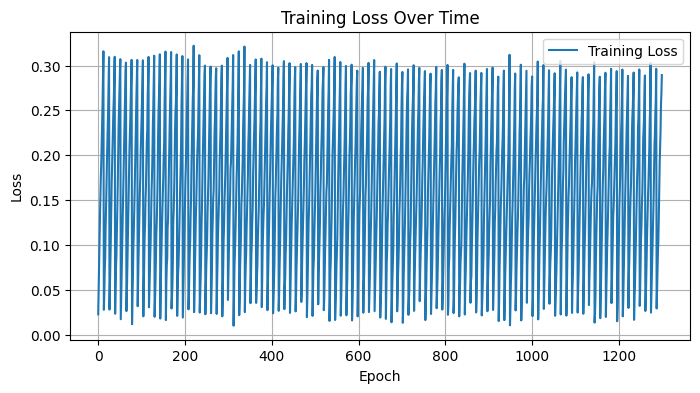

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-37-35f44895142a>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


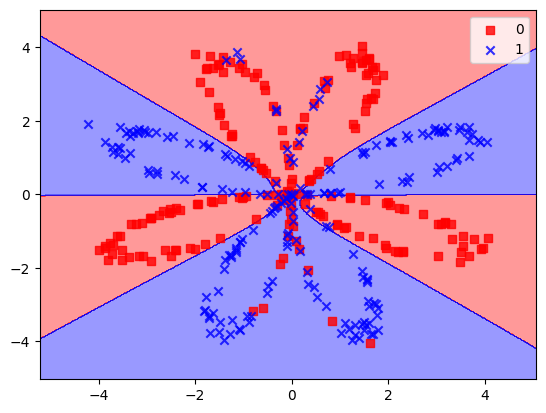

In [37]:
# prompt:  Plot the loss and decision boundary after the training

from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = predict(classifier, np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
plot_decision_regions(x, y.ravel(), model)
plt.legend()
plt.show()

## 7. Experiments 1: Try LeakyReLU as `activation_1` with the size of `hidden_1` = 4, 5, and 10. You can reuse the same model without copying it.

## 8. (3 pt) Comment on the number of the straight lines with respect to the size of the hidden layer.

## 9. Experiments 2: with the `hidden_1` layer of the size 4 try Sigmoind, ReLU, LeakyReLU, ELU, and SiLU as `activation_1`. Do this for batch sizes 4 and 50.

## 10. (4 pt) Comment on the shape of the decision boundaries with respect to the activation function and the batch size. Did you adjust the learning rate? Did you try to start with small learning rate like 0.001 instead of 0.01 and if so, which worked better?